In [1]:
import sys

sys.path.append("../")

In [2]:
import requests
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from stats_arb.tests import adf_test, kpss_test, cal_half_life, pp_test
from datetime import datetime, timedelta
from ta.volatility import BollingerBands
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (18,7)


In [3]:
API_BASE = 'https://fapi.binance.com/fapi/v1/'
TIMEFRAME = '1h'

LABELS = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]

DROP_COLUMNS=[
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]


def get_batch(symbol, interval='1m', start_time=0, limit=1000):
    """Use a GET request to retrieve a batch of candlesticks. Process the JSON into a pandas
    dataframe and return it. If not successful, return an empty dataframe.
    """

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }
    try:
        # timeout should also be given as a parameter to the function
        response = requests.get(f'{API_BASE}klines', params, timeout=30)
    except requests.exceptions.ConnectionError:
        print('Connection error, Cooling down for 5 mins...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.Timeout:
        print('Timeout, Cooling down for 5 min...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    if response.status_code == 200:
        return pd.DataFrame(response.json(), columns=LABELS)
    
    print(f'Got erroneous response back {symbol}: {response}. {response.text}')
    return pd.DataFrame([])


def get_candles(base, quote, start_date: datetime, interval='1m'):
    batches = []

    last_timestamp = int(start_date.timestamp()) * 1000
    # gather all candlesticks available, starting from the last timestamp loaded from disk or 0
    # stop if the timestamp that comes back from the api is the same as the last one
    previous_timestamp = None

    while previous_timestamp != last_timestamp:
        # stop if we reached data from today
        if datetime.fromtimestamp(last_timestamp / 1000) >= datetime.utcnow():
            break

        previous_timestamp = last_timestamp

        new_batch = get_batch(
            symbol=base + quote,
            interval=interval,
            start_time=last_timestamp
        )

        # requesting candles from the future returns empty
        # also stop in case response code was not 200
        if new_batch.empty:
            break

        last_timestamp = new_batch['open_time'].max()

        # sometimes no new trades took place yet on date.today();
        # in this case the batch is nothing new
        if previous_timestamp == last_timestamp:
            break

        batches.append(new_batch)
        last_datetime = datetime.fromtimestamp(last_timestamp / 1000)

        covering_spaces = 20 * ' '
        print(datetime.now(), base, quote, interval, str(last_datetime) + covering_spaces, end='\r', flush=True)

    if len(batches) > 0:
        # write clean version of csv to parquet
        df = pd.concat(batches, ignore_index=True)
        df.drop(columns=DROP_COLUMNS, inplace=True)
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        return df



In [4]:
nb_symbols = 2

def calculate_spread(df, symbols, hedge_ratio):
    spread = None
    for i in range(nb_symbols):
        if spread is None:
            spread = df[symbols[i]] * hedge_ratio[i]
        else:
            spread += df[symbols[i]] * hedge_ratio[i]
    
    spread.dropna(inplace=True)
    return spread

In [5]:
sns.set_context("paper", font_scale=1.8)

def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

def plot_spread(spread):
    # CHANGING MATPLOTLIB STYLE
    with sns.axes_style("darkgrid"):
        spread.plot() # Plot the spread
        plt.axhline(spread.mean(), color='red', linestyle='--') # Add the mean
        plt.xlabel('Time')
        plt.legend(['Price Spread', 'Mean'])
        plt.show()

def plot_zscore(spread, half_life):
    with sns.axes_style("darkgrid"):
        zscore(spread, half_life).plot()
        plt.axhline(0, color='black')
        plt.axhline(2, color='red', linestyle='--')
        plt.axhline(-2, color='green', linestyle='--')
        plt.axhline(4, color='red', linestyle='--')
        plt.axhline(-4, color='green', linestyle='--')
        plt.legend(['Spread z-score', 'Mean', '+1', '-1'])
        plt.show()

In [6]:
def check_pair(symbols, hedge_ratio, half_life):
    data = []

    for symbol in symbols:
        df = get_candles(base=symbol, quote='USDT', start_date=datetime.now() - timedelta(days=60), interval=TIMEFRAME)
        if df is None:
            continue

        df.rename(columns={'close': symbol}, inplace=True)
        # the data is too long, just limit to recent period
        log = np.log(df[symbol].astype(np.float32))
        data.append(log)

    df = pd.concat(data, axis=1)
    df = df.dropna(axis=1, how='all')

    spread = calculate_spread(df, symbols, hedge_ratio=hedge_ratio)
    plot_spread(spread)
    plot_zscore(spread, half_life)
    print(adf_test(spread, verbose=True))
    # return spread

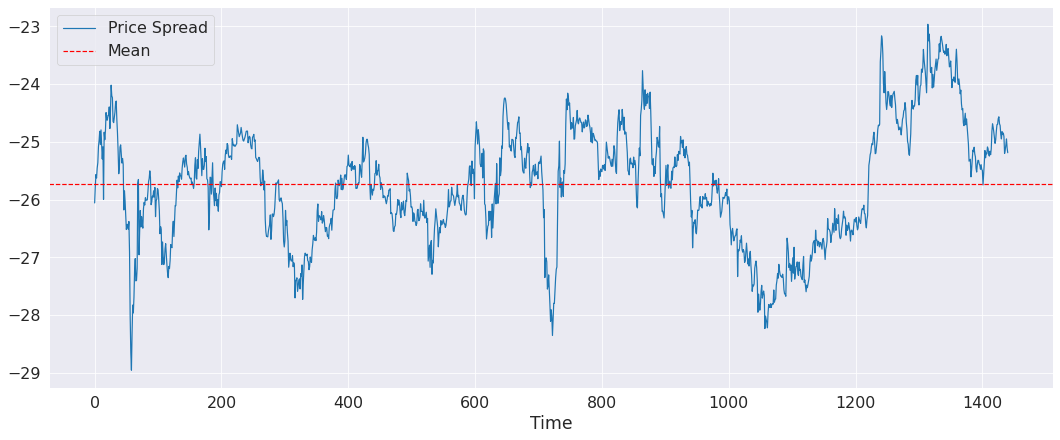

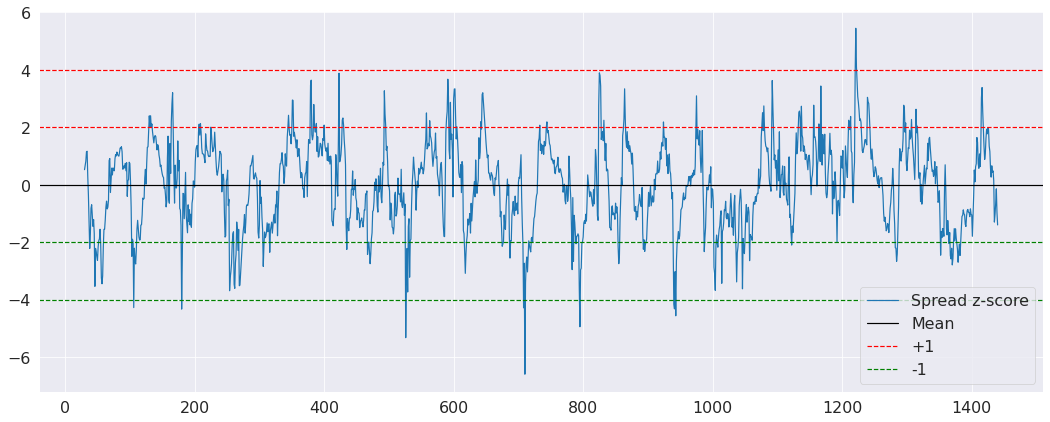

Results of Dickey-Fuller Test:
Result: The series is  stationary
0.0010673986614936038


In [11]:
symbols = ['ADA', 'MANA']
half_life = 30
hedge_ratio = [39.09738679, -32.57724902]

check_pair(symbols, hedge_ratio, half_life)

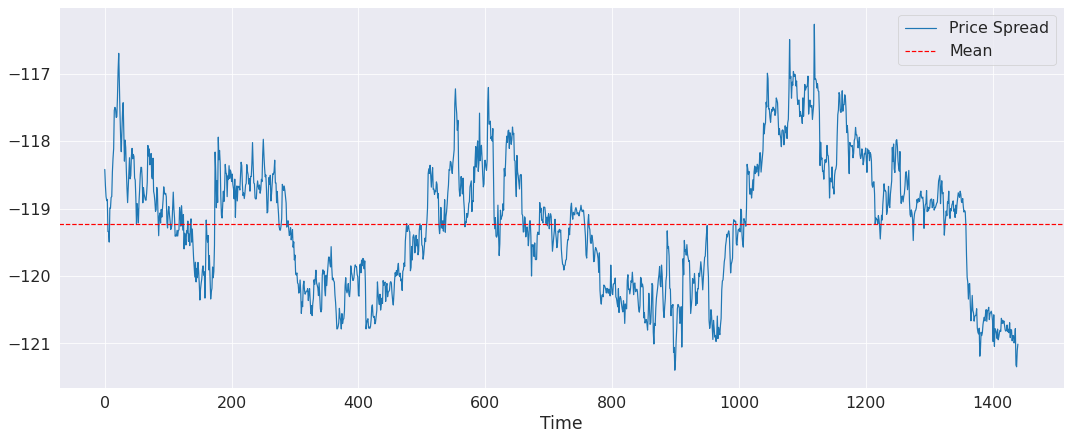

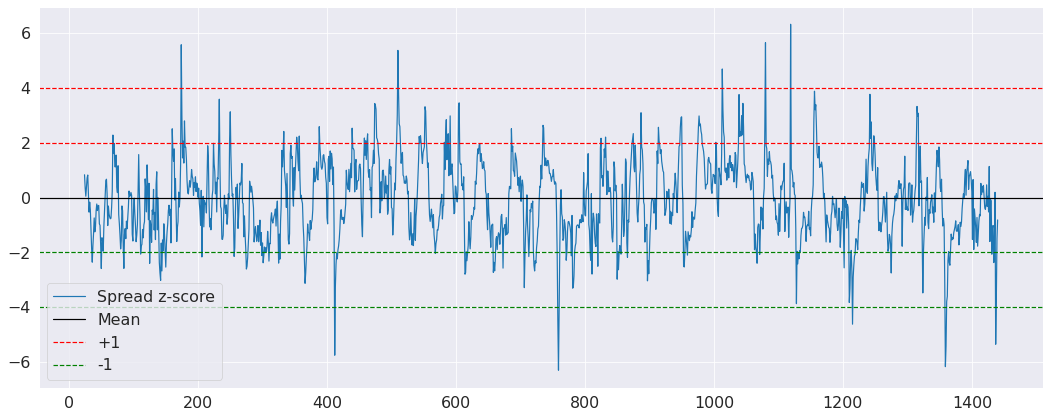

Results of Dickey-Fuller Test:
Result: The series is  stationary
0.02289993613685051


In [9]:
symbols = ['ALGO', 'SOL']
half_life = 24
hedge_ratio = [ 37.77000641, -21.1557718 ]

check_pair(symbols, hedge_ratio, half_life)

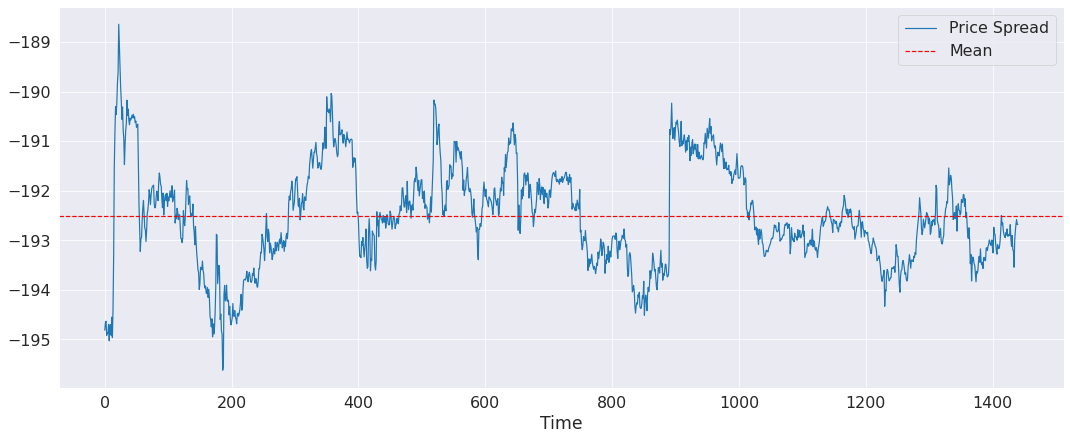

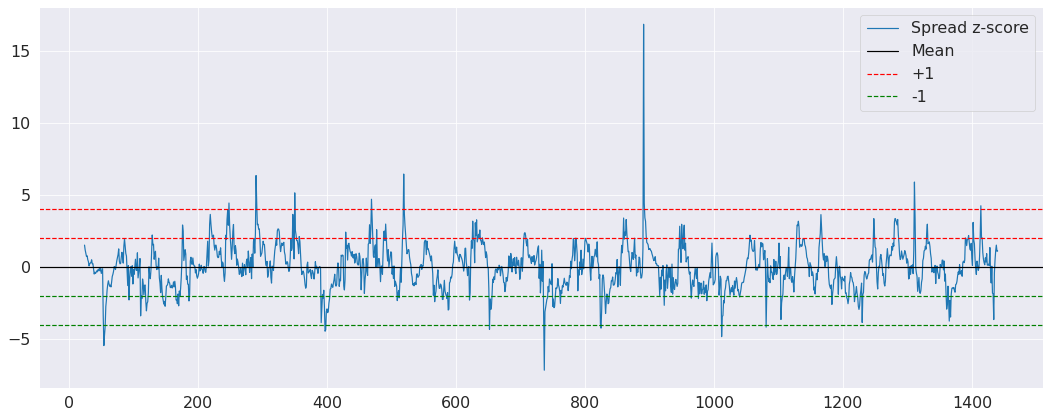

Results of Dickey-Fuller Test:
Result: The series is  stationary
7.499952590870183e-05


In [10]:
symbols = ['XRP', 'LTC']
half_life = 24
hedge_ratio = [46.0195636, -35.85354947]

spread = check_pair(symbols, hedge_ratio, half_life=half_life)
